# Alpaca Dataset

We se the dataset from https://github.com/gururise/AlpacaDataCleaned/tree/main

In [1]:
import json
import numpy as np
import torch
from transformers import AutoTokenizer

import os 
import sys

sys.path.append(os.path.join(os.getcwd(), "../../"))

import src.visualization.plot_rawdata as plotutils

In [2]:
DATA_PATH = "../raw_instruct/alpaca_data_cleaned.json"
# Open the JSON file
with open(DATA_PATH, 'r') as file:
    data = json.load(file)  # Load the JSON data into a Python dictionary

In [3]:
print(f"Type of data: {type(data)}\nNumber of entries: {len(data)}")

Type of data: <class 'list'>
Number of entries: 51760


In [4]:
idx = 0

In [5]:
type(data[idx])

dict

In [6]:
data[idx]

{'instruction': 'Give three tips for staying healthy.',
 'input': '',
 'output': '1. Eat a balanced and nutritious diet: Make sure your meals are inclusive of a variety of fruits and vegetables, lean protein, whole grains, and healthy fats. This helps to provide your body with the essential nutrients to function at its best and can help prevent chronic diseases.\n\n2. Engage in regular physical activity: Exercise is crucial for maintaining strong bones, muscles, and cardiovascular health. Aim for at least 150 minutes of moderate aerobic exercise or 75 minutes of vigorous exercise each week.\n\n3. Get enough sleep: Getting enough quality sleep is crucial for physical and mental well-being. It helps to regulate mood, improve cognitive function, and supports healthy growth and immune function. Aim for 7-9 hours of sleep each night.'}

In [7]:
for i, elem in enumerate(data): 
    if elem['input'] and i > 6:
        idx = i
        break

In [8]:
idx

8

#### Check if all elements in data are of type dict and if just one input prompt per data sample (no conversation)

In [9]:
for elem in data:
    if not isinstance(elem, dict):
        print(f"Elem is not a dict! {elem}")
    elif sorted(list(elem.keys())) != sorted(['input', 'instruction', 'output']):
        print(f"Elem has different keys in dict! {elem}")

### No data

In [10]:
no_conver_data = []

for elem in data: 
    if not elem['instruction']:
        no_conver_data.append(elem)

So all of the elements in this dataset have an instruction!

## Input handling
Each sample in the dataset is of type `dict`.
The keys of that `dict` are `['instruction', 'input', 'output']`. However, the tokenizers do not recognize the `'input'` keyword, so we need to append it to the user's `content`.  

In [11]:
access_tk = os.getenv("HF_API_TOKEN")
device_str = "cuda:0"
model_name = "meta-llama/Llama-3.2-3B-Instruct"
padding_side='left'

tokenizer = AutoTokenizer.from_pretrained(model_name, token=access_tk, device_map=device_str, torch_dtype=torch.float16, padding_side=padding_side)

In [12]:
def get_tokens(sentence, tokenizer):
    return tokenizer.apply_chat_template(sentence, return_tensors="pt", add_generation_prompt=True)  

In [13]:
from src.data.rawdata_processor import alpaca_generate_rawprompt_text, build_rawprompt_text_batch, build_rawprompt_text_chat

In [14]:
mystring = alpaca_generate_rawprompt_text(data[idx], tokenizer, truncate=False)
print(mystring)

Evaluate this sentence for spelling and grammar mistakes
Input: He finnished his meal and left the resturant


In [15]:
build_rawprompt_text_chat(mystring)

[{'role': 'user',
  'content': 'Evaluate this sentence for spelling and grammar mistakes\nInput: He finnished his meal and left the resturant'}]

In [16]:
get_tokens(build_rawprompt_text_chat(mystring), tokenizer)

tensor([[128000, 128006,   9125, 128007,    271,  38766,   1303,  33025,   2696,
             25,   6790,    220,   2366,     18,    198,  15724,   2696,     25,
            220,    605,   3297,    220,   2366,     20,    271, 128009, 128006,
            882, 128007,    271,  83445,    420,  11914,    369,  43529,    323,
          32528,  21294,    198,   2566,     25,   1283,   1913,     77,   3384,
            813,  15496,    323,   2163,    279,   2800,    324,    519, 128009,
         128006,  78191, 128007,    271]])

In [17]:
print(tokenizer.decode(get_tokens(build_rawprompt_text_batch(mystring, 5), tokenizer)[0]))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 10 May 2025

<|eot_id|><|start_header_id|>user<|end_header_id|>

Evaluate this sentence for spelling and grammar mistakes
Input: He finnished his meal and left the resturant<|eot_id|><|start_header_id|>assistant<|end_header_id|>




### Analyze COMPLETE DATASET lenght of prompts in terms of number of tokens

In [18]:
tmp_model_input = [build_rawprompt_text_chat(alpaca_generate_rawprompt_text(elem, tokenizer, truncate=False)) for elem in data]

In [19]:
len(tmp_model_input)

51760

In [20]:
conv_len_tokens = [get_tokens(elem, tokenizer).shape[1] for elem in tmp_model_input]

In [21]:
len(conv_len_tokens)

51760

In [22]:
np.max(conv_len_tokens)

np.int64(634)

In [23]:
import importlib
importlib.reload(plotutils)

<module 'src.visualization.plot_rawdata' from '/home/daniel/Documents/llm-testbed/data/notebooks/../../src/visualization/plot_rawdata.py'>

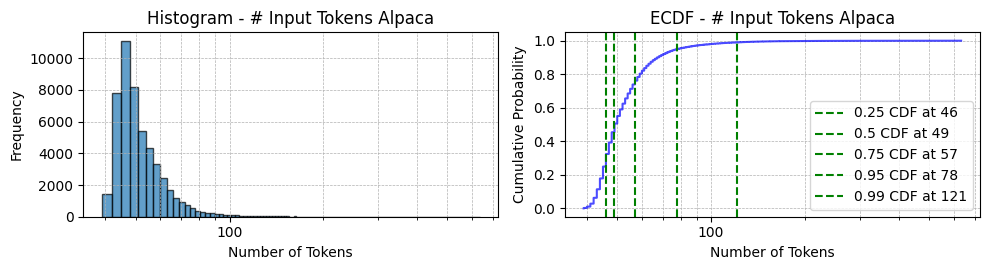

In [29]:
fig = plotutils.plot_histogram_and_cdf(conv_len_tokens, in_size=(10, 2.8), 
                                       in_title="# Input Tokens Alpaca", n_bins=200, 
                                       x_forcdf=0, cdf_forx=[0.25, 0.5, 0.75, 0.95, 0.99], logx=True)
# fig = plotutils.plot_histogram_and_cdf(conv_len_tokens, in_size=(10, 2.8), 
#                                        in_title="# Input Tokens Alpaca", n_bins=80,
#                                        x_forcdf=0, cdf_forx=[0.25, 0.5, 0.75, 0.95, 0.999])

In [30]:
fig.savefig("../../outputs/images/raw_data_Alpaca_COMPLETE_ntokens_hist.pdf", bbox_inches="tight")

# Split the datasets

In [31]:
SEED = 42
MAXIMUM = 2000

In [32]:
np.random.seed(SEED)

In [33]:
tmp = np.arange(len(data))
np.random.shuffle(tmp)

In [34]:
idx_subset = min(MAXIMUM, len(data))
tmp = tmp[0:idx_subset]
print(f"SELECTING {len(tmp)} samples randomly from dataset")

SELECTING 2000 samples randomly from dataset


In [35]:
train_indxs, val_indxs, test_indxs = np.split(tmp, [int(0.7*len(tmp)), int(0.9*len(tmp))])

In [36]:
print(f"Selecting {len(train_indxs)} training, {len(val_indxs)} validation, and {len(test_indxs)} test samples")

Selecting 1400 training, 400 validation, and 200 test samples


In [37]:
data_train = [data[i] for i in train_indxs]
data_val = [data[i] for i in val_indxs]
data_test = [data[i] for i in test_indxs]

In [38]:
# Check if the lengths agree
print(f"Percentage of training data: {round(len(data_train)/len(data), 4)}")
print(f"Percentage of validation data: {round(len(data_val)/len(data), 4)}")
print(f"Percentage of test data: {round(len(data_test)/len(data), 4)}")

Percentage of training data: 0.027
Percentage of validation data: 0.0077
Percentage of test data: 0.0039


### Analyze TRIMMED DATASET lenght of prompts in terms of number of tokens

In [39]:
tmp_model_input = [build_rawprompt_text_chat(alpaca_generate_rawprompt_text(elem, tokenizer)) for elem in [data[k] for k in tmp]]

In [40]:
len(tmp_model_input)

2000

In [41]:
conv_len_tokens = [get_tokens(elem, tokenizer).shape[1] for elem in tmp_model_input]

In [42]:
len(conv_len_tokens)

2000

In [43]:
np.max(conv_len_tokens)

np.int64(397)

In [46]:
print(f"MEAN: {np.mean(conv_len_tokens)}\nMIN: {np.min(conv_len_tokens)},\nMAX: {np.max(conv_len_tokens)}")
print(*[f"P{p}: {v:.2f}" for p, v in zip([25, 50, 75, 99], np.percentile(conv_len_tokens, [25, 50, 75, 99]))])

MEAN: 53.7385
MIN: 39,
MAX: 397
P25: 45.00 P50: 49.00 P75: 57.00 P99: 114.01


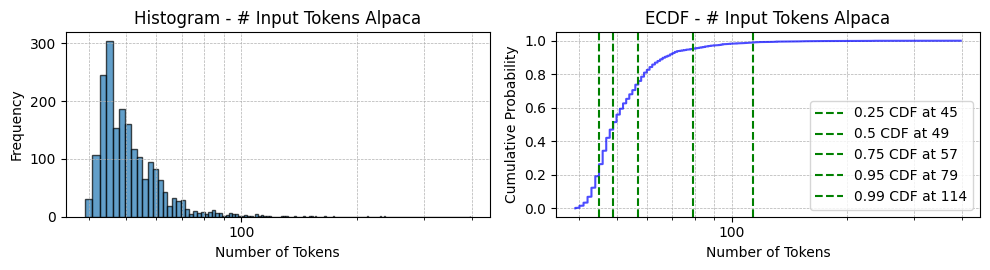

In [44]:
fig = plotutils.plot_histogram_and_cdf(conv_len_tokens, in_size=(10, 2.8), 
                                       in_title="# Input Tokens Alpaca", n_bins=200, 
                                       x_forcdf=0, cdf_forx=[0.25, 0.5, 0.75, 0.95, 0.99], logx=True)
# fig = plotutils.plot_histogram_and_cdf(conv_len_tokens, in_size=(10, 2.8), 
#                                        in_title="# Input Tokens Alpaca", 
#                                        x_forcdf=0, cdf_forx=[0.25, 0.5, 0.75, 0.95, 0.999])

In [45]:
fig.savefig("../../outputs/images/raw_data_Alpaca_ntokens_hist.pdf", bbox_inches="tight")

## Save Datasets

In [42]:
def save_data(dataset, path):
    with open(path, 'w') as f:
        json.dump(dataset, f)
    print(f"Dataset saved to path {path}")

In [44]:
save_path_src = "../raw_instruct/Alpaca/raw_Alpaca"

In [45]:
save_data(data_train, save_path_src + "_train.json")

Dataset saved to path ../raw_instruct/Alpaca/raw_Alpaca_train.json


In [46]:
save_data(data_val, save_path_src + "_validate.json")

Dataset saved to path ../raw_instruct/Alpaca/raw_Alpaca_validate.json


In [47]:
save_data(data_test, save_path_src + "_test.json")

Dataset saved to path ../raw_instruct/Alpaca/raw_Alpaca_test.json


# PREVIOUS CODE

In [8]:
sentence=[{'role': "user",
           "content": "Hi ChatGPT. Do you think you can tell me the sum of a and b?\nInput: a=10, b=20"}]

In [9]:
def get_tokens(sentence, tokenizer):
    return tokenizer.apply_chat_template(sentence, return_tensors="pt", add_generation_prompt=True)   

In [10]:
print(tokenizer.batch_decode(get_tokens(sentence, tokenizer))[0])

<bos><start_of_turn>user
Hi ChatGPT. Do you think you can tell me the sum of a and b?
Input: a=10, b=20<end_of_turn>
<start_of_turn>model



In [11]:
# Find the first data sample with a 'input' element.
for i,elem in enumerate(data): 
    if elem['input']:
        tmp = elem['instruction']+"\nInput: "+elem['input']
        print(f"Index: {i}\nPrompt:\n'{tmp}'")
        break

Index: 6
Prompt:
'Explain why the following fraction is equivalent to 1/4
Input: 4/16'


In [12]:
get_tokens([{'role': 'user',
             'content': data[6]['instruction']+"\nInput: "+data[6]['input']}], 
           tokenizer)

tensor([[     2,    106,   1645,    108,  74198,   3165,    573,   2412,  17441,
            603,  13107,    577, 235248, 235274, 235283, 235310,    108,   3678,
         235292, 235248, 235310, 235283, 235274, 235318,    107,    108,    106,
           2516,    108]])

In [13]:
print(tokenizer.batch_decode(get_tokens([{'role': 'user',
                                          'content': data[6]['instruction']+"\nInput: "+data[6]['input']}], 
                                        tokenizer))[0])

<bos><start_of_turn>user
Explain why the following fraction is equivalent to 1/4
Input: 4/16<end_of_turn>
<start_of_turn>model



In [14]:
get_tokens(sentence, tokenizer).shape

torch.Size([1, 38])

#### Do the above for all conversations that start with human

In [15]:
tmp_model_input = list()
for elem in data:
    if elem['input']:
        tmp_model_input.append([{'role': 'user',
                                'content': elem['instruction']+"\nInput: "+elem['input']}])
    else:
        tmp_model_input.append([{'role': 'user', 'content': elem['instruction']}])

In [16]:
len(tmp_model_input)

51760

In [17]:
conv_len_tokens = [get_tokens(elem, tokenizer).shape[1] for elem in tmp_model_input]

In [18]:
len(conv_len_tokens)

51760

In [19]:
np.max(conv_len_tokens)

629

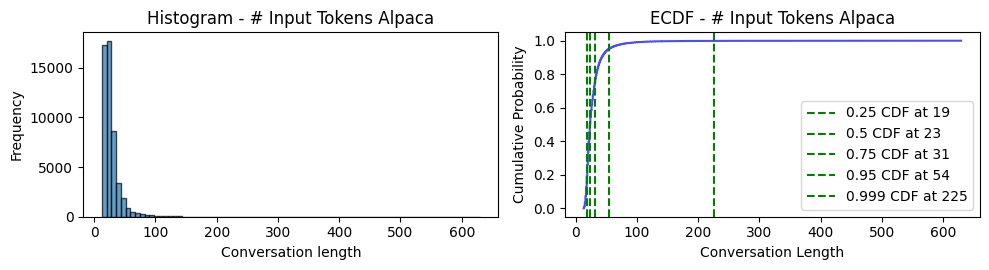

In [23]:
fig = plotutils.plot_histogram_and_cdf(conv_len_tokens, in_size=(10, 2.8), 
                             in_title="# Input Tokens Alpaca", x_forcdf=0, 
                                       cdf_forx=[0.25, 0.5, 0.75, 0.95, 0.999],
                                      n_bins=80)

In [24]:
fig.savefig("../../outputs/images/raw_data_AlpacaCleaned_ntokens_hist.pdf", bbox_inches="tight")

In [25]:
tmp = np.arange(len(data))
np.random.shuffle(tmp)
print(tmp[0:20])

[ 3911  4314 32267  1561 15401 20412 23805 15851 42243 46087 14824 47831
 42459 51721 37231 45408  4811 20492  5838 19595]


In [26]:
train_indxs, val_indxs, test_indxs = np.split(tmp, [int(0.7*len(tmp)), int(0.9*len(tmp))])

In [27]:
data_train = [data[i] for i in train_indxs]
data_val = [data[i] for i in val_indxs]
data_test = [data[i] for i in test_indxs]

In [29]:
# Check if the lengths agree
print(f"Percentage of training data: {round(len(data_train)/len(data), 4)}")
print(f"Percentage of validation data: {round(len(data_val)/len(data), 4)}")
print(f"Percentage of test data: {round(len(data_test)/len(data), 4)}")

Percentage of training data: 0.7
Percentage of validation data: 0.2
Percentage of test data: 0.1
